In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

In [10]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
from scipy import stats
import statsmodels.api as sm
from itertools import product

In [11]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv("./Data/crypto-markets.csv", parse_dates = ['date'], index_col  = 'date', date_parser = dateparse)
df.head()

C:\Users\annar\AppData\Local\Temp\ipykernel_22032\120803995.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [12]:
# working only on bitcoin's data
btc_data = df[df['symbol'] == 'BTC']
btc_data.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [13]:
#dropping uneccesary columns
btc_data.drop(['slug', 'volume', 'symbol', 'name', 'ranknow', 'market', 'close_ratio', 'spread'], axis = 1, inplace = True)
btc_data.head()

C:\Users\annar\AppData\Local\Temp\ipykernel_22032\185885820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data.drop(['slug', 'volume', 'symbol', 'name', 'ranknow', 'market', 'close_ratio', 'spread'], axis = 1, inplace = True)


,open,high,low,close
date,,,,
2013-04-28,135.30,135.98,132.10,134.21
2013-04-29,134.44,147.49,134.00,144.54
2013-04-30,144.00,146.93,134.05,139.00
2013-05-01,139.00,139.89,107.72,116.99
2013-05-02,116.38,125.60,92.28,105.21


In [14]:
# take user input for the year to work with

year = input("Input the year for which you want the stats: ")

In [15]:
btc_data.loc[year].head()

,open,high,low,close
date,,,,
2017-01-01,963.66,1003.08,958.70,998.33
2017-01-02,998.62,1031.39,996.70,1021.75
2017-01-03,1021.60,1044.08,1021.60,1043.84
2017-01-04,1044.40,1159.42,1044.40,1154.73
2017-01-05,1156.73,1191.10,910.42,1013.38


#### Monthly Forecasting

In [16]:
btc_month = btc_data.resample('M').mean()
btc_month.head()

,open,high,low,close
date,,,,
2013-04-30,137.913333,143.466667,133.383333,139.250000
2013-05-31,120.292258,123.949032,114.253548,119.993226
2013-06-30,108.856333,111.300667,104.602333,107.761333
2013-07-31,90.311613,93.869032,86.719355,90.512258
2013-08-31,113.041935,116.002258,111.388065,113.905161


Dickey–Fuller test: p=0.998803


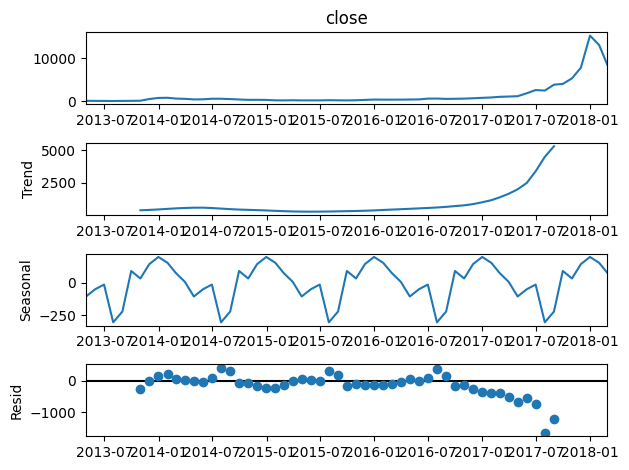

In [19]:
'''
STATIONARY CHECK

if a time series is staionary, 
it implies the lack of broad trends in data
'''
seasonal_decompose(btc_month.close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close)[1])


##### The value of p obtained form Dickey-fuller test, suggests that the series is not stationary with 99.88% confidence.

Dickey–Fuller test: p=0.494475


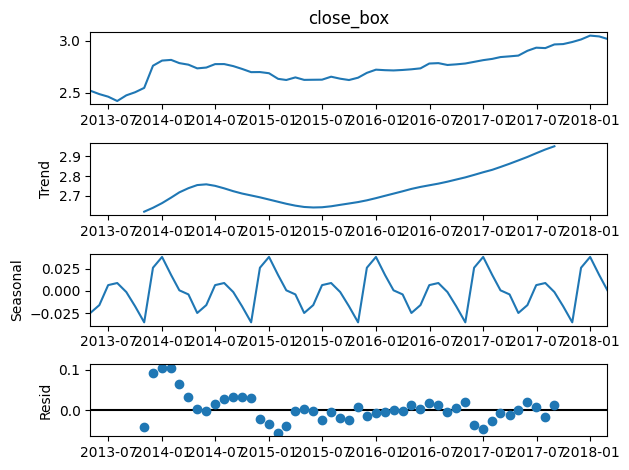

In [26]:
'''
Box-Cox Transformation
Whenever you use it the parameter needs to be estimated from the data. 
In time series the process could have a non-constant variance. 
If the variance changes with time the process is nonstationary. 
It is often desirable to transform a time series to make it stationary.
'''

btc_month['close_box'], lmbda = stats.boxcox(btc_month.close)
seasonal_decompose(btc_month.close_box).plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

##### The p value suggests that the time series is not stationary

#### Differencing

A pre-processing step in forecasting time series data by calculating sequentially xt−xt−1)until we get to a point where the series is stationary